In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.utils import normalize

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import MAPE, MAE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

#---Import moduls from stock-prediction package
from stock_prediction.data_prep import Data_Prep
from stock_prediction.features_exo import exo_selection

#---API related
import os 
from math import sqrt 
import yfinance as yf
from datetime import date, timedelta, datetime
from stock_prediction.data_prep_api import Data_Prep_Api
from stock_prediction.features_exo_api import exo_selection_api

In [21]:
company_dict = {
    'asml' : 'ASML.AS',
    'lvmh': 'MC.PA',
    'sap' : 'SAP.DE',
    'linde' : 'LIN',
    'siemens' : 'SIE.DE',
    'total' : 'FP.PA',
    'sanofi' : 'SAN.PA',
    'allianz' : 'ALV.DE', 
    'schneider' : 'SU.PA',
    'iberdrola' : 'IBE.MC',
    'enel' : 'ENEL.MI',
    'air-liquide' : 'AI.PA',
    'basf' : 'BAS.DE',
    'bayer' : 'BAYN.DE',
    'adidas' : 'ADS.DE',
    'airbus' : 'AIR.PA',
    'adyen' : 'ADYEN.AS',
    'deutsche-telecom' : 'DTE.DE',
    'daimler' : 'DAI.DE',
    'bnp' : 'BNP.PA',
    'anheuser-busch' : 'ABI.BR',
    'vinci' : 'DG.PA',
    'banco-santander' : 'SAN.MC',
    'philips' : 'PHIA.AS',
    'kering' : 'KER.PA',
    'deutsche-post' : 'DPW.DE',
    'axa' : 'CS.PA',
    'safran' : 'SAF.PA',
    'danone'  : 'BN.PA',
    'essilor' : 'EL.PA',
    'intensa' : 'ISP.MI',
    'munchener' : 'MUV2.DE',
    'pernod' : 'RI.PA',
    'vonovia' : 'VNA.DE',
    'vw' : 'VOW3.DE',
    'ing' : 'INGA.AS',
    'crh' : 'CRG.IR',
    'industria-diseno' : 'ITX.MC',
    'kone' : 'KNEBV.HE',
    'deutsche-borse' : 'DB1.DE',
    'ahold' : 'AHOG.DE',
    'flutter' : 'FLTR.IR',
    'amadeus' : 'AMS.MC',
    'engie' : 'ENGI.PA',
    'bmw' : 'BMW.DE',
    'vivendi' : 'VIV.PA',
    'eni' : 'ENI.MI',
    'nokia' : 'NOKIA.HE'
}

In [115]:
# def load_data(first_date='2012-01-01') :
#         '''laod data from api yfinance'''
#         if first_date!='max':
#             return yf.download(company_dict['vinci'],
#                                start=str(first_date),
#                                end=str(date.today()))
#         else:
#             return yf.download(company_dict[name], period="max")

In [117]:
# load_data()

In [37]:
def load_data_api(company, start_date='2020-01-03', end_date='2020-12-31', len_=20):

    prep_class = Data_Prep_Api(company, len_)
    df = prep_class.data_prep_api(max=True) # (max=True)
    prep_class.select_features_api(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                        Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                        Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    df = exo_selection_api(df, ["sp500", "eurusd", "crude", "vix"], max=True) # ,max=True) "nasdaq", "gold",

    df = df.sort_values('Date')

    start_date_delta = str((datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=len_)).date()) # replace with extracted len_ from loaded model
    mask = (df['Date'] >= start_date_delta) & (df['Date'] < end_date)
    df = df.loc[mask]

     #rebase
    df = prep_class.Price_Rebase_api(df)
    
    df = df.set_index('Date')
    
    idx = df.columns[8][7:]

    return df, idx

In [38]:
vinci, index = load_data_api('vinci')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [39]:
index

'DG.PA_R'

In [19]:
vinci.head()

,High-Low_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Period_Volum_DG.PA,Period_Vol_DG.PA,Period_Volum_stoxx_50,DG.PA_relatif,Vix_No_Rebase,Return_DG.PA_R,Return_stoxx_50_R,Return_sp500_R,Return_eurusd_R,Return_crude_R
Date,,,,,,,,,,,,,
2019-12-16,0.006682,0.002217,0.004454,-0.067925,0.134958,-0.057062,-0.001398,0.1214,100.000000,100.000000,100.000000,100.000000,100.000000
2019-12-17,0.008713,0.006877,0.001824,0.131083,0.133886,0.156095,0.003852,0.1229,99.657323,99.272148,100.033529,100.112485,101.212422
2019-12-18,0.014962,0.014962,0.000000,0.516900,0.138901,0.035319,-0.011470,0.1258,98.347107,99.105690,99.990285,100.241988,101.195817
2019-12-19,0.013872,0.005751,0.008075,0.405637,0.138479,0.092035,-0.002095,0.1250,98.145528,99.110194,100.436171,99.923295,101.677466
2019-12-20,0.020119,0.000000,0.020119,1.589596,0.155320,1.406583,0.010539,0.1251,100.161252,100.101254,100.932805,100.013352,100.381996


In [22]:
# To avoid data leakage we have to split sets chronologically.

def train_test_val_split(df, horizon=1, train_threshold=0.6, val_threshold=0.8):
    
    # here gap=0, if we take a longer horizon it'll matter
    gap = horizon - 1

    # set a train: 60%, test: 20%, val: 20% sizes
    train = int( train_threshold*df.shape[0])
    val = int(val_threshold*df.shape[0])


    df_train = df[:train]
    df_val = df[train:val]
    df_test = df[val+gap:] # gap can matter later
    
    return df_train, df_val, df_test

In [23]:
def shift_sequences(df, idx, length=20, horizon=1):
    
    """This function is able to get as many subsequences for X and a corresponding target y
    Nas possible, taking in account lenght of sequence and horizon."""

    last_possible = df.shape[0] - length - horizon    
    X=[]
    y=[]
    for start in range(last_possible):
        X.append(df[start: start+length].values)
        y.append(df.iloc[start+length+horizon-1][f'Return_{idx}'])
    
    # random permutation of the sequences to train
    perm = np.random.permutation(last_possible)
    X = np.array(X)[perm, :, :]
    y = np.array(y)[perm]
    return X, y

In [24]:
def shift_sequences_pred(df, idx, length=20, horizon=1):
    
    """This function is able to get as many subsequences for X and a corresponding target y
    Nas possible, taking in account lenght of sequence and horizon."""
    
    last_possible = df.shape[0] - length - horizon
    X=[]
    y=[]
    for start in range(last_possible):
        X.append(df[start: start+length].values)
        y.append(df.iloc[start+length+horizon-1][f'Return_{idx}'])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [96]:
#---Pipeline
def train_model(df,
                idx,
                train_threshold=0.6,
                val_threshold=0.8,
                nb_sequences=50,
                len_=30,
                l_rate=0.001,
                momentum=0.9,
                loss='MAE',
                metric=MAE,
                patience=50,
                batch_size=128,
                horizon=1,
                plot_history=False,
                verbose=2):
    """Train model function:
    Allows to split sequences and gets X and y for train, val, test sets;
    Initializes a model with (Normalization), LSTM/GRU/Conv1D and 2 fully connected layers.
    Returns: X_train, y_train, X_val, y_val, X_test, y_test, model"""
    
#     regul = 0

    if not isinstance(df, list):
        df = [df]

    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_test = []
    y_test = []
    for nb_df, df_loc in enumerate(df):
        idx_loc = idx[nb_df]
        
        #---Split train, test, val sets
        df_train, df_val, df_test = train_test_val_split(df_loc,
                                                         train_threshold=train_threshold,
                                                         val_threshold=val_threshold)
        #---Get train, test, val X and y sequences
    #     X_train_loc, y_train_loc = get_X_y(df_train, idx_loc, length=len_, number_of_sequences=nb_sequences)
    #     X_val_loc, y_val_loc = get_X_y(df_val, idx_loc, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)
    #     X_test_loc, y_test_loc = get_X_y(df_test, idx_loc, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)

            
        X_train_loc, y_train_loc = shift_sequences_pred(df_train, idx_loc, length=len_)
        X_val_loc, y_val_loc = shift_sequences_pred(df_val, idx_loc, length=len_)
        X_test_loc, y_test_loc = shift_sequences_pred(df_test, idx_loc, length=len_)
        
        X_train.append(X_train_loc)
        y_train.append(y_train_loc)
        
        X_val.append(X_val_loc)
        y_val.append(y_val_loc)
        
        X_test.append(X_test_loc)
        y_test.append(y_test_loc)
    
    # Data concatenation
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_val = np.concatenate(X_val)
    y_val = np.concatenate(y_val)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
    
    # Data shuffle (random, different for train / val / test)
    perm = np.random.permutation(len(X_train))
    X_train, y_train = X_train[perm], y_train[perm]
    perm = np.random.permutation(len(X_val))
    X_val, y_val = X_val[perm], y_val[perm]
    perm = np.random.permutation(len(X_test))
    X_test, y_test = X_test[perm], y_test[perm]
    
#     print(np.any(np.isnan(X_train)))
#     print(np.any(np.isnan(X_val)))
#     print(np.any(np.isnan(X_test)))

    normalizer = Normalization()
    normalizer.adapt(X_train)  # , axis=-1, order=1 as minmax

    #---Initialize the model
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(len_, X_train.shape[-1])))
    model.add(normalizer)
    #     model.add(layers.BatchNormalization(input_shape=(len_,X_train.shape[-1])))
    
#     model.add(layers.GRU(50, return_sequences=True, activation='tanh'))
#     model.add(layers.GRU(30, return_sequences=True, activation='tanh'))
#     model.add(layers.GRU(20, return_sequences=False, activation='tanh'))

    model.add(layers.Conv1D(256, 2, activation='relu', kernel_initializer="glorot_uniform"))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Conv1D(128, 2, activation='relu', kernel_initializer="glorot_uniform"))
    model.add(layers.Dropout(0.1))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Conv1D(64, 2, activation='relu', kernel_initializer="glorot_uniform"))
    model.add(layers.Dropout(0.1))
    model.add(layers.MaxPool1D(pool_size=2))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(16, activation='relu', kernel_initializer="glorot_uniform"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform"))
    
#     model.add(layers.LSTM(50, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.LSTM(30, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.LSTM(20, return_sequences=False, activation='tanh', kernel_regularizer=regularizers.l2(regul)))

#     model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(regul)))
#     model.add(layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l2(regul)))

    model.compile(
        loss=loss,
        optimizer=Adam(l_rate),  # RMSprop(learning_rate=l_rate, momentum=momentum), 
        metrics=[metric])
    
#     print(X_train.shape)
#     print(model.summary())

    es = EarlyStopping(monitor='val_loss',
                       patience=patience,
                       restore_best_weights=True)
    
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                           patience=round(patience/2))

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es, lr],
                        verbose=verbose)

    if plot_history:

        plot_loss(history, patience)

    return X_train, y_train, X_val, y_val, X_test, y_test, model

In [75]:
#---Plot train val losses function

def plot_loss(history, patience):
    plt.semilogy(history.history['loss']) # plot train loss
    plt.semilogy(history.history['val_loss']) # plot val loss
    plt.title('Loss & Metric')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
#     plt.plot(history.history['mean_absolute_percentage_error'])
#     plt.plot(history.history['val_mean_absolute_percentage_error'])
#     plt.title('MAPE')
#     plt.ylabel('Mean Absolute Percentage Error')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='best')
#     plt.show()
    
    stop_epoch = max(history.epoch)-patience
    val_mae = history.history['val_mean_absolute_percentage_error'][stop_epoch] #val_mean_absolute_error

    print(f"early stopping at {max(history.epoch)} epoch.\nval_mae: {val_mae}")

**Load data to train choosing commanies**

In [40]:
#---load the data with selected features to train with for 'vinci'
data = []
idx = []
for company in ['vinci']: #company_dict.keys()
    # # Pre-covid data
    data_loc, idx_loc = load_data_api(company, start_date='2012-01-01', end_date='2019-10-04') #start_date='2017-05-31', end_date='2019-10-04'
    data.append(data_loc)  
    idx.append(idx_loc)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


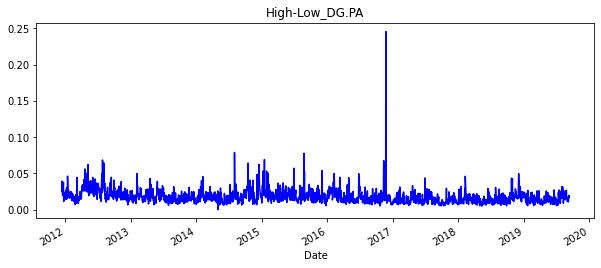

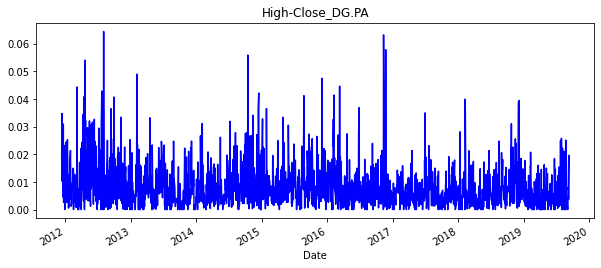

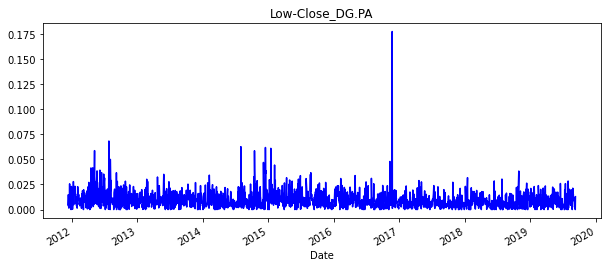

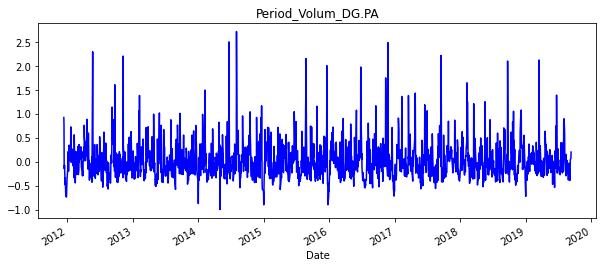

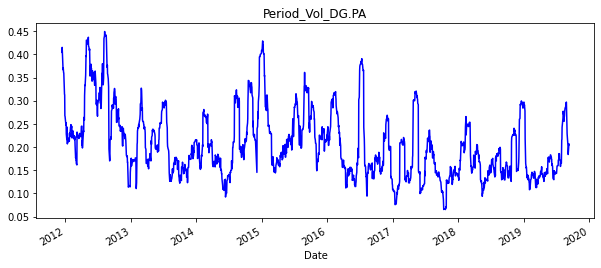

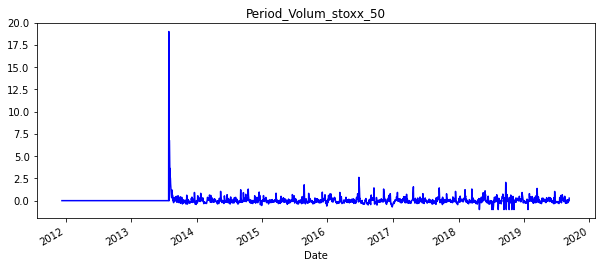

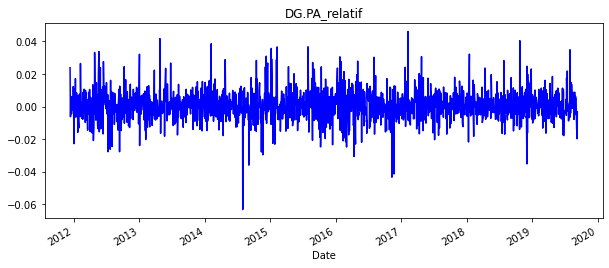

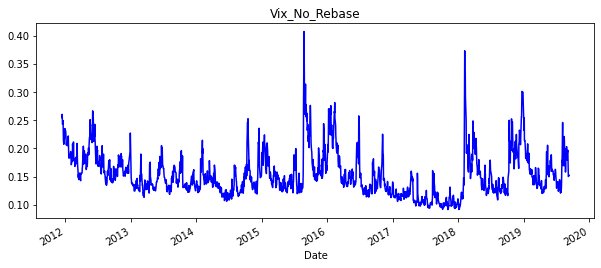

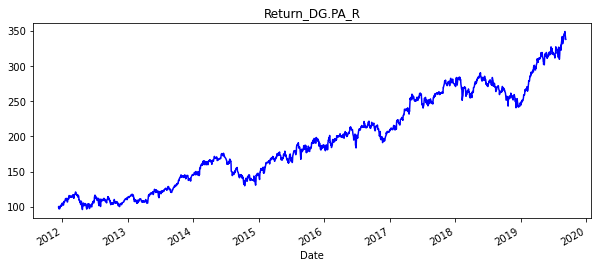

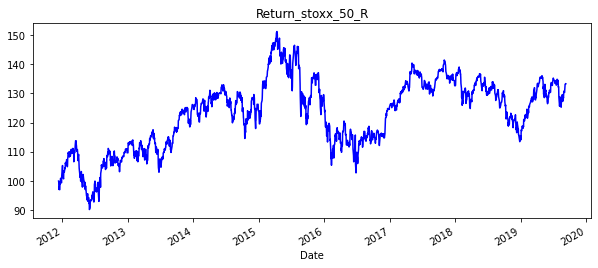

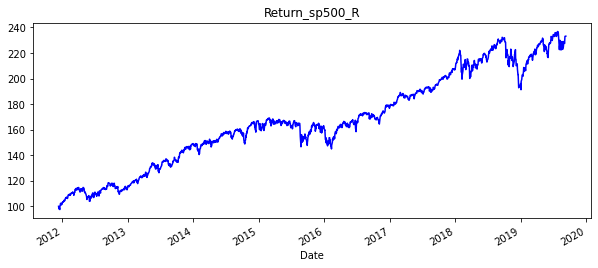

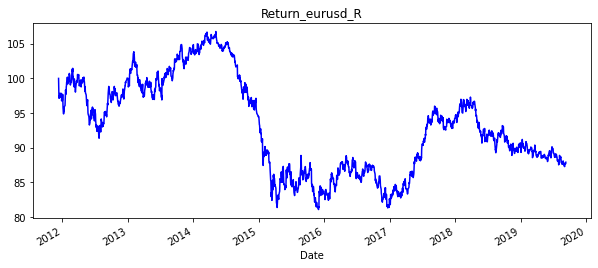

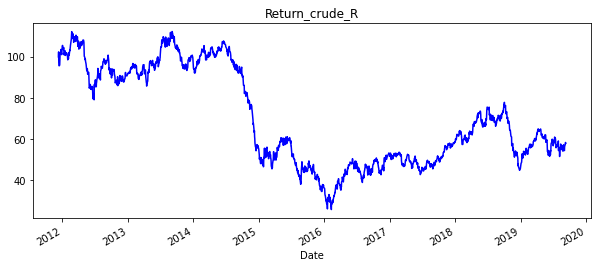

In [43]:
#---Plot the temporal progression of different features of our training data

%matplotlib inline

for col in data[0].columns:
    color="green" if col == f"Return_{idx}" else "blue"
    data[0][col].plot(figsize=(10,4), color=color)
    plt.title(col)

    plt.show()

Epoch 1/1000
18/18 - 2s - loss: 44.5062 - mean_absolute_percentage_error: 44.5062 - val_loss: 53.4678 - val_mean_absolute_percentage_error: 53.4678
Epoch 2/1000
18/18 - 0s - loss: 20.0826 - mean_absolute_percentage_error: 20.0826 - val_loss: 15.7642 - val_mean_absolute_percentage_error: 15.7642
Epoch 3/1000
18/18 - 1s - loss: 16.1604 - mean_absolute_percentage_error: 16.1604 - val_loss: 25.4345 - val_mean_absolute_percentage_error: 25.4345
Epoch 4/1000
18/18 - 1s - loss: 14.2403 - mean_absolute_percentage_error: 14.2403 - val_loss: 24.2603 - val_mean_absolute_percentage_error: 24.2603
Epoch 5/1000
18/18 - 1s - loss: 14.4358 - mean_absolute_percentage_error: 14.4358 - val_loss: 28.3770 - val_mean_absolute_percentage_error: 28.3770
Epoch 6/1000
18/18 - 1s - loss: 14.0433 - mean_absolute_percentage_error: 14.0433 - val_loss: 29.0717 - val_mean_absolute_percentage_error: 29.0717
Epoch 7/1000
18/18 - 1s - loss: 13.1017 - mean_absolute_percentage_error: 13.1017 - val_loss: 23.9738 - val_mean

18/18 - 1s - loss: 11.1747 - mean_absolute_percentage_error: 11.1747 - val_loss: 26.2068 - val_mean_absolute_percentage_error: 26.2068
Epoch 57/1000
18/18 - 1s - loss: 12.0113 - mean_absolute_percentage_error: 12.0113 - val_loss: 25.2712 - val_mean_absolute_percentage_error: 25.2712
Epoch 58/1000
18/18 - 1s - loss: 11.5432 - mean_absolute_percentage_error: 11.5432 - val_loss: 24.9299 - val_mean_absolute_percentage_error: 24.9299
Epoch 59/1000
18/18 - 1s - loss: 11.5258 - mean_absolute_percentage_error: 11.5258 - val_loss: 24.9070 - val_mean_absolute_percentage_error: 24.9070
Epoch 60/1000
18/18 - 1s - loss: 11.6893 - mean_absolute_percentage_error: 11.6893 - val_loss: 26.3285 - val_mean_absolute_percentage_error: 26.3285
Epoch 61/1000
18/18 - 1s - loss: 11.2925 - mean_absolute_percentage_error: 11.2925 - val_loss: 25.2629 - val_mean_absolute_percentage_error: 25.2629
Epoch 62/1000
18/18 - 1s - loss: 11.6668 - mean_absolute_percentage_error: 11.6668 - val_loss: 22.5758 - val_mean_absolu

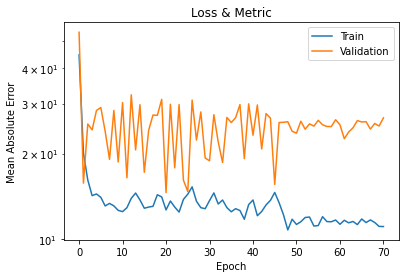

early stopping at 70 epoch.
val_mae: 14.59220027923584


In [97]:
X_train, y_train, X_val, y_val, X_test, y_test, model_vinci = train_model(data, idx, l_rate=0.01, batch_size=64, loss='MAPE', metric=MAPE, plot_history=True)

In [82]:
#baseline mape
(np.mean(np.abs(X_test[:,-1, 8]-y_test) / np.abs(y_test))) * 100

0.8333322829488028

Prediction of stock return on J+1: [[270.49777]
 [243.59697]
 [274.26364]
 [323.42056]
 [285.3821 ]
 [285.63052]
 [277.4323 ]
 [261.54013]
 [270.94247]
 [274.15213]
 [272.055  ]
 [240.47668]
 [280.38455]
 [314.23434]
 [303.65164]
 [284.80557]
 [281.84274]
 [254.58157]
 [258.34634]
 [266.65125]
 [276.65594]
 [276.9025 ]
 [331.71912]
 [242.99872]
 [273.58005]
 [274.808  ]
 [313.78754]
 [261.6512 ]
 [270.6437 ]
 [283.38898]
 [284.91714]
 [269.19806]
 [252.58806]
 [330.47974]
 [301.5834 ]
 [266.723  ]
 [307.71637]
 [287.47702]
 [273.15622]
 [280.61588]
 [317.1857 ]
 [249.12923]
 [251.41646]
 [305.48856]
 [249.58195]
 [284.81046]
 [269.13513]
 [324.68356]
 [328.2156 ]
 [251.9404 ]
 [283.68304]
 [250.73355]
 [281.91574]
 [329.3702 ]
 [259.892  ]
 [280.71585]
 [241.25371]
 [321.81805]
 [246.13454]
 [280.90604]
 [251.65726]
 [276.18503]
 [271.95   ]
 [283.44193]
 [280.7733 ]
 [292.56296]
 [282.0563 ]
 [280.43762]
 [241.48143]
 [273.2076 ]
 [277.95456]
 [278.1998 ]
 [313.16678]
 [275.29333]
 [2

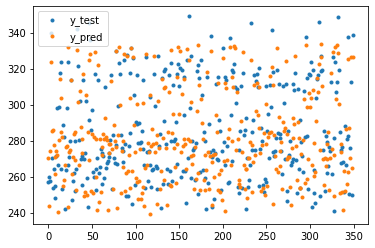

In [99]:
#---Prediction
res = model_vinci.evaluate(X_test, y_test, verbose=0)
y_pred = model_vinci.predict(X_test)

plt.plot(y_test, '.',  label='y_test')
plt.plot(y_pred, '.', label='y_pred') #'.'
plt.legend()

print(f"Prediction of stock return on J+1: {y_pred} with mae {res[1]}")

In [100]:
X_test[:,-1, 8]

array([259.92110819, 258.83003883, 257.21775   , 335.98773731,
       270.35137642, 254.82052675, 264.15918679, 249.41731933,
       256.29958469, 274.57353025, 291.50508553, 264.9332464 ,
       297.89045911, 316.34770844, 317.34917347, 270.15644963,
       255.80010934, 291.22744183, 283.24770926, 245.45814289,
       267.09793456, 301.08311713, 322.72871851, 268.81707439,
       274.06390608, 283.73247881, 317.05699617, 242.75059908,
       258.2157125 , 263.96324293, 243.13089582, 281.05192361,
       263.27679179, 337.44551041, 327.1626165 , 281.58440396,
       304.43147315, 271.52052926, 257.87709232, 269.89664695,
       310.92452449, 269.27370683, 271.5551516 , 307.26865285,
       255.60292401, 250.51044535, 291.643893  , 341.61063276,
       331.6143335 , 284.77269329, 299.27853376, 262.36422503,
       261.87346674, 326.82439493, 250.99811948, 262.00407775,
       266.18164022, 315.30082031, 259.52361652, 267.75093495,
       272.92397387, 254.49402655, 273.92398276, 269.89

In [90]:
s = pd.Series([X_test[:,-1, 8], y_pred ])
return_ = s.pct_change(1)
return_[1]

array([[ 0.0882292 ,  0.11146598,  0.26545066, ...,  0.25257536,
         0.27500407,  0.24856052],
       [ 0.18408399,  0.20936755,  0.3769157 , ...,  0.3629063 ,
         0.38731061,  0.35853782],
       [-0.06279414, -0.04278214,  0.0898327 , ...,  0.07874422,
         0.0980603 ,  0.07528656],
       ...,
       [-0.05517487, -0.03500017,  0.0986928 , ...,  0.08751417,
         0.10698728,  0.0840284 ],
       [-0.02758355, -0.0068197 ,  0.13077745, ...,  0.11927238,
         0.13931416,  0.11568481],
       [-0.02497553, -0.00415599,  0.1338102 , ...,  0.12227427,
         0.1423698 ,  0.11867708]])

**Prediction on selected time period**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


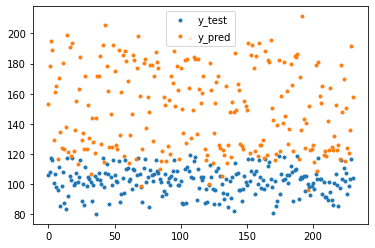

In [61]:
#---Select time period
data_to_predict, idx_ = load_data_api('vinci', start_date='2020-06-13', end_date = '2021-06-14')

#---Create sequences for X and y
X_test_, y_test_ = shift_sequences(df = data_to_predict, idx = idx_, length=30)

prediction_vinci = model_vinci.predict(X_test_)

plt.plot(y_test_, '.', label='y_test')
plt.plot(prediction_vinci, '.', label = 'y_pred') #['vinci']
plt.legend()

In [62]:
prediction_vinci

array([[153.27455 ],
       [178.50641 ],
       [194.82088 ],
       [189.27945 ],
       [129.15298 ],
       [161.35324 ],
       [165.02322 ],
       [116.84729 ],
       [170.44899 ],
       [134.69305 ],
       [124.156815],
       [180.50189 ],
       [123.099846],
       [137.7561  ],
       [199.0957  ],
       [121.1109  ],
       [191.04659 ],
       [118.94924 ],
       [193.57771 ],
       [121.666   ],
       [135.95444 ],
       [155.1958  ],
       [113.62781 ],
       [163.28624 ],
       [184.11792 ],
       [129.1263  ],
       [134.15976 ],
       [123.44564 ],
       [171.79984 ],
       [123.35728 ],
       [152.38681 ],
       [130.60184 ],
       [106.86477 ],
       [143.75659 ],
       [128.03513 ],
       [120.53368 ],
       [143.64124 ],
       [171.96333 ],
       [171.72893 ],
       [185.07288 ],
       [126.56613 ],
       [192.4856  ],
       [114.98878 ],
       [205.49557 ],
       [178.17722 ],
       [162.1207  ],
       [124.774445],
       [146.4

In [62]:
# model_vinci.save('model_cnn_vinci_tr_2012_2019_f20')

INFO:tensorflow:Assets written to: model_cnn_vinci_tr_2012_2019_f20/assets


**For the selected training period test different slices, then experiment with features**

In [66]:
np.arange(10,110,10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [79]:
def test_len_sequence(df, idx, start=20, stop=110, step=10):
    
    """This function computes MAPE in given range
    to find best nb_sequences"""
    
    len_grid = np.arange(start, stop, step)
    MAE = []

    for len_ in len_grid:
            X_train, y_train, X_val, y_val, X_test, y_test, model = train_model(df, idx, len_=len_, verbose=0)
            res = model.evaluate(X_test, y_test)
            MAE.append((len_, res[1]))
            baseline = np.mean(np.abs(y_test))
            ecart = 100*(baseline - res[1])/baseline
            print(f"For lenght of sequence {len_} the MAE is of {res[1]:.6f}, baseline is of {baseline:.6f}, ecart {ecart:.6f}%")

In [80]:
test_len_sequence(data, idx)

12/12 [==============================] - 0s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0084
For lenght of sequence 20 the MAE is of 0.008401, baseline is of 0.008405, ecart 0.040298%
11/11 [==============================] - 0s 4ms/step - loss: 0.0083 - mean_absolute_error: 0.0083
For lenght of sequence 30 the MAE is of 0.008323, baseline is of 0.008335, ecart 0.139283%
11/11 [==============================] - 0s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0084
For lenght of sequence 40 the MAE is of 0.008373, baseline is of 0.008382, ecart 0.103744%
11/11 [==============================] - 0s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0084
For lenght of sequence 50 the MAE is of 0.008428, baseline is of 0.008431, ecart 0.039418%
10/10 [==============================] - 0s 5ms/step - loss: 0.0085 - mean_absolute_error: 0.0085
For lenght of sequence 60 the MAE is of 0.008548, baseline is of 0.008550, ecart 0.028523%
10/10 [==============================] - 0s 6ms/step - 

**Selected slice=30, it allows a better performance compared to baseline**

Epoch 1/1000
9/9 - 1s - loss: 0.2272 - mean_absolute_error: 0.2272 - val_loss: 0.0596 - val_mean_absolute_error: 0.0596
Epoch 2/1000
9/9 - 0s - loss: 0.1029 - mean_absolute_error: 0.1029 - val_loss: 0.0488 - val_mean_absolute_error: 0.0488
Epoch 3/1000
9/9 - 0s - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178
Epoch 4/1000
9/9 - 0s - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0160 - val_mean_absolute_error: 0.0160
Epoch 5/1000
9/9 - 0s - loss: 0.0248 - mean_absolute_error: 0.0248 - val_loss: 0.0124 - val_mean_absolute_error: 0.0124
Epoch 6/1000
9/9 - 0s - loss: 0.0194 - mean_absolute_error: 0.0194 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 7/1000
9/9 - 0s - loss: 0.0180 - mean_absolute_error: 0.0180 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 8/1000
9/9 - 0s - loss: 0.0155 - mean_absolute_error: 0.0155 - val_loss: 0.0084 - val_mean_absolute_error: 0.0084
Epoch 9/1000
9/9 - 0s - loss: 0.0146 - m

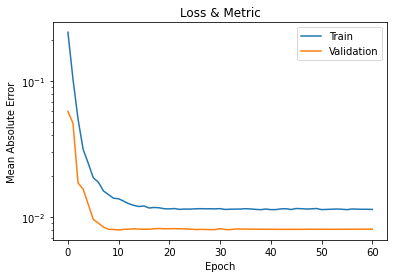

early stopping at 60 epoch.
val_mae: 0.008040184155106544


In [134]:
X_train_30, y_train_30, X_val_30, y_val_30, X_test_30, y_test_30, model_30 = train_model(data,
                                                                      idx,
                                                                      batch_size=128,
                                                                      l_rate=0.001,
                                                                      len_=30,
                                                                      plot_history=True)

In [164]:
baseline = np.mean(abs(y_test_30))
baseline

0.008334563756297049

Prediction of stock return on J+1: [[ 3.8540452e-03]
 [-4.2843407e-05]
 [ 1.9585206e-03]
 [ 8.1896572e-04]
 [-1.1187086e-04]
 [-7.6251180e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [ 2.1875103e-03]
 [-1.0519322e-03]
 [-1.8154093e-03]
 [ 2.6219431e-03]
 [ 2.3065205e-03]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.8876616e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [ 8.5937476e-04]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [ 6.3228147e-04]
 [-1.1187086e-04]
 [ 3.2841931e-03]
 [-1.1187086e-04]
 [ 7.3472544e-04]
 [-1.1187086e-04]
 [ 2.7962513e-03]
 [-3.0808308e-04]
 [ 1.4527437e-03]
 [-1.1187086e-04]
 [-2.7929624e-03]
 [ 1.2129971e-03]
 [-1.1187086e-04]
 [-1.1187086e-04]
 [-3.7875419e-05]
 [-3.0336648e-03]
 [ 1.4520198e-03]
 [-1.1187086e-04]
 [-7.5916958e-04]
 [ 4.8172572e-03]
 [ 1.1569554e-03]
 [ 2.1165304e-03]
 [ 3.7796986e-03]
 [-2.4926811e-03]
 [-1.1187086e-04]
 [-9.046305

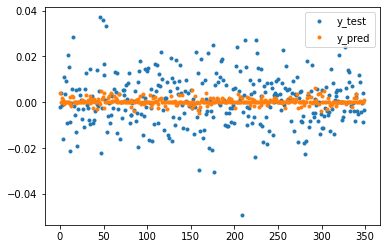

In [135]:
#---Prediction
res_30 = model_30.evaluate(X_test_30, y_test_30, verbose=0)
y_pred_30 = model_30.predict(X_test_30)

plt.plot(y_test_30, '.',  label='y_test')
plt.plot(y_pred_30, '.', label='y_pred') #'.'
plt.legend()

print(f"Prediction of stock return on J+1: {y_pred_30} with mae {res_30[1]}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


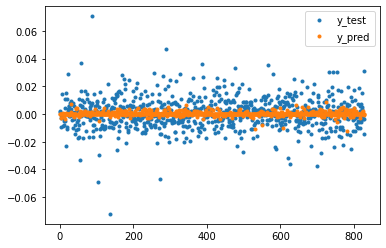

In [138]:
#---Select time period
data_to_predict, idx_ = load_data_api('vinci', start_date='2016-01-01', end_date = '2019-06-14')

#---Create sequences for X and y
X_test_, y_test_ = shift_sequences(df = data_to_predict, idx = idx_, length=30)

prediction_30 = model_30.predict(X_test_)

plt.plot(y_test_, '.', label='y_test')
plt.plot(prediction_30, '.', label = 'y_pred') #['vinci']
plt.legend()

In [139]:
prediction_30

array([[-1.11870861e-04],
       [-1.11870861e-04],
       [-2.79296236e-03],
       [ 3.44195636e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [ 7.34725443e-04],
       [-1.11870861e-04],
       [-2.25774152e-03],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-3.80780920e-03],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [ 9.81320278e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.01693650e-03],
       [-4.95899469e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [ 6.99520763e-03],
       [-1.11870861e-04],
       [ 1.33301993e-03],
       [-1.11870861e-04],
       [-1.03590824e-03],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-1.11870861e-04],
       [-2.47896556e-03],
       [-1.1

In [140]:
model_vinci.save('../stock_prediction/saved_models_cnn/model_cnn_vinci_tr_2012_2019_f30_lr0001')

INFO:tensorflow:Assets written to: ../stock_prediction/saved_models_cnn/model_cnn_vinci_tr_2012_2019_f30_lr0001/assets


**Slice=30, lr=0.001, test for vinci within 2012-2019 training period, take Low_Close and High_Close features.**

In [431]:
def load_data_api(company, start_date='2020-01-03', end_date='2020-12-31', len_=30):

    prep_class = Data_Prep_Api(company, len_)
    df = prep_class.data_prep_api(max=True) # (max=True)
    
    prep_class.select_features_api(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
                        Volume_Change=False, Period_Volum=True, Annual_Vol=False,
                        Period_Vol=False, Return_Index=True, Volum_Index=True, Relative_Return=False)
    
#     prep_class.select_features_api(df, Return = True, Log_Return=False, High_Low=True, High_Close=True, Low_Close=True,
#                         Volume_Change=False, Period_Volum=False, Annual_Vol=False,
#                         Period_Vol=False, Return_Index=False, Volum_Index=False, Relative_Return=False)

    df = exo_selection_api(df, ["sp500", "eurusd", "crude", "vix"], max=True) # ,max=True) "nasdaq", "gold",

    df = df.sort_values('Date')

    start_date_delta = str((datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=len_)).date()) # replace with extracted len_ from loaded model
    mask = (df['Date'] >= start_date_delta) & (df['Date'] < end_date)
    df = df.loc[mask]

    df = df.set_index('Date')

    idx = df.columns[0][7:]

    return df, idx

In [432]:
#---load the data with selected features to train with for 'vinci'
data_feat = []
idx_feat = []
for company in company_dict.keys(): #company_dict.keys()
    # # Pre-covid data
    data_loc, idx_loc = load_data_api(company, start_date='2012-01-01', end_date='2019-10-04') #start_date='2017-05-31', end_date='2019-10-04'
    data_feat.append(data_loc)  
    idx_feat.append(idx_loc)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/home/khody/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/home/khody/.pyenv/versions/3.8.6/envs/stock_prediction/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [414]:
data_feat[0].head()

,Return_ASML.AS,High-Low_ASML.AS,High-Close_ASML.AS,Low-Close_ASML.AS,Period_Volum_ASML.AS,Period_Vol_ASML.AS,Return_stoxx_50,Period_Volum_stoxx_50,ASML.AS_relatif,Return_sp500,Return_eurusd,Return_crude,Vix_No_Rebase
Date,,,,,,,,,,,,,
2011-12-02,0.030282,0.020769,0.001336,0.019408,-0.143524,0.286861,0.012386,0.0,0.017896,-0.000241,0.001710,0.007585,0.2752
2011-12-05,0.027889,0.025037,0.004387,0.020560,-0.012511,0.295824,0.011479,0.0,0.016410,0.010287,-0.003556,0.000297,0.2784
2011-12-06,0.002924,0.020727,0.005184,0.015463,0.043591,0.294314,-0.005352,0.0,0.008276,0.001106,-0.002410,0.002872,0.2813
2011-12-07,0.010206,0.019156,0.006735,0.012338,0.097187,0.289451,-0.005003,0.0,0.015209,0.002018,0.001891,-0.007800,0.2867
2011-12-08,-0.000160,0.016019,0.007057,0.008900,-0.045788,0.274284,-0.024252,0.0,0.024092,-0.021142,-0.000617,-0.021395,0.3059


Epoch 1/1000
408/408 - 7s - loss: 0.0174 - mean_absolute_error: 0.0174 - val_loss: 0.0086 - val_mean_absolute_error: 0.0086
Epoch 2/1000
408/408 - 6s - loss: 0.0127 - mean_absolute_error: 0.0127 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 3/1000
408/408 - 6s - loss: 0.0121 - mean_absolute_error: 0.0121 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 4/1000
408/408 - 6s - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091
Epoch 5/1000
408/408 - 6s - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0092 - val_mean_absolute_error: 0.0092
Epoch 6/1000
408/408 - 6s - loss: 0.0110 - mean_absolute_error: 0.0110 - val_loss: 0.0094 - val_mean_absolute_error: 0.0094
Epoch 7/1000
408/408 - 6s - loss: 0.0106 - mean_absolute_error: 0.0106 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 8/1000
408/408 - 6s - loss: 0.0103 - mean_absolute_error: 0.0103 - val_loss: 0.0096 - val_mean_absolute_error: 0.0096
Epoch 9/

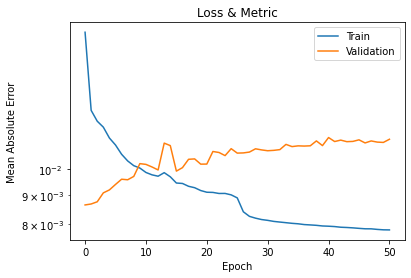

early stopping at 50 epoch.
val_mae: 0.00863824412226677


In [433]:
X_train_feat, y_train_feat, X_val_feat, y_val_feat, X_test_feat, y_test_feat, model_feat = train_model(data_feat,
                                                                                                       idx_feat,
                                                                                                       patience=50,
                                                                                                       l_rate=0.001,
                                                                                                       plot_history=True)

In [434]:
baseline_feat = np.mean(abs(y_test_feat))
baseline_feat

0.010156085370338722

Prediction of stock return on J+1: [[-1.5530735e-05]
 [ 1.1647344e-03]
 [-1.7936341e-04]
 ...
 [ 1.3604388e-04]
 [ 1.0612980e-03]
 [-1.5482865e-04]] with mae 0.010370847769081593


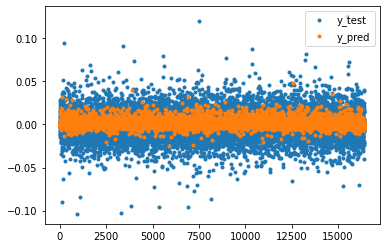

In [435]:
#---Prediction
res_feat = model_feat.evaluate(X_test_feat, y_test_feat, verbose=0)
y_pred_feat = model_feat.predict(X_test_feat)

plt.plot(y_test_feat, '.',  label='y_test')
plt.plot(y_pred_feat, '.', label='y_pred') #'.'
plt.legend()

print(f"Prediction of stock return on J+1: {y_pred_feat} with mae {res_feat[1]}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


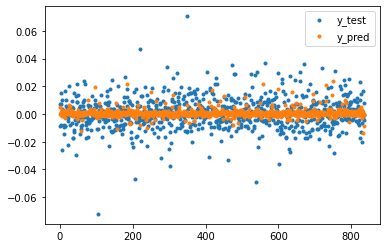

In [436]:
#---Select time period
data_to_predict, idx_ = load_data_api('vinci', start_date='2016-01-01', end_date = '2019-06-14')

#---Create sequences for X and y
X_test_, y_test_ = shift_sequences(df = data_to_predict, idx = idx_, length=30)

prediction_feat = model_feat.predict(X_test_)

plt.plot(y_test_, '.', label='y_test')
plt.plot(prediction_feat, '.', label = 'y_pred') #['vinci']
plt.legend()

In [437]:
prediction_feat

array([[ 5.07906079e-05],
       [ 4.99479845e-03],
       [ 9.21206549e-04],
       [-4.75032255e-04],
       [ 1.27581134e-03],
       [ 2.68931314e-03],
       [ 4.23997641e-04],
       [-1.16679817e-03],
       [ 3.39660794e-04],
       [-1.60178356e-03],
       [ 2.11524218e-03],
       [-6.77816570e-04],
       [-1.28719956e-04],
       [ 1.53663009e-03],
       [-2.88270041e-03],
       [-7.94902444e-05],
       [ 1.51665136e-03],
       [ 7.81036913e-04],
       [ 4.23753634e-04],
       [ 2.14572996e-04],
       [ 1.53255090e-03],
       [ 1.04787573e-03],
       [-1.97248533e-04],
       [ 3.51100415e-03],
       [ 6.35272264e-03],
       [ 7.44810328e-04],
       [-1.39810145e-04],
       [ 5.41267172e-03],
       [-3.19916755e-04],
       [ 5.33975661e-04],
       [ 4.64236364e-04],
       [ 2.77233869e-03],
       [ 1.53742731e-04],
       [ 2.51191109e-03],
       [ 5.38496301e-04],
       [-1.09727867e-03],
       [-7.17110932e-04],
       [-1.34884939e-03],
       [ 1.3

- low_close, high_close, high_low: val_mae=0.0078247, predict_mae = 0.0084163, baseline = 0.008425862 (batch_size=64)

In [438]:
model_feat.save('../stock_prediction/saved_models_cnn/model_cnn_all_tr_2012_2019_f30_lr0001_p50_/')

INFO:tensorflow:Assets written to: ../stock_prediction/saved_models_cnn/model_cnn_all_tr_2012_2019_f30_lr0001_p50_/assets
